In [1]:
from IPython import display
from pathlib import Path
import shutil
import yaml

display.clear_output()

# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Prevent ultralytics from tracking activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.4.14 🚀 Python-3.13.11 torch-2.10.0 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 36.0 GB RAM, 280.2/460.4 GB disk)


---
# Phase 1: Dataset cleaning - remove duplicates

Purpose:
- Remove duplicates only, not low-quality images. Low-quality detection is noisy and risks false negatives early.

Strategy:
- Keep low-quality images until later phases where the model can decide validity more reliably.
- This avoids over-filtering too early.

Model choice for removing duplicates:
- CleanVision
- imagededup

### Check original dataset

In [2]:
data_path = Path(f"../{config['paths']['original_raw']}")
image_count = len(list(data_path.rglob('*.png')))
print(f"Total images in original_raw: {image_count}")

Total images in original_raw: 1147


## Choice 1: CleanVision
- CleanVision gives duplicate groups via `imagelab.info['exact_duplicates']`

In [3]:
from ultralytics import YOLO
from IPython.display import display, Image
from cleanvision import Imagelab
from tqdm import tqdm

/Users/carlychinsekyi/miniconda3/envs/vision/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reading images from /Users/carlychinsekyi/Downloads/GitHub/vision-pipeline-dataset-cleaner/notebooks/../data/original_raw
Checking for exact_duplicates, near_duplicates images ...


Computing hashes: 100%|██████████| 1147/1147 [00:01<00:00, 627.37it/s]


Issue checks completed. 279 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          279 |
|  1 | near_duplicates  |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 279
Examples representing most severe instances of this issue:

Set: 0


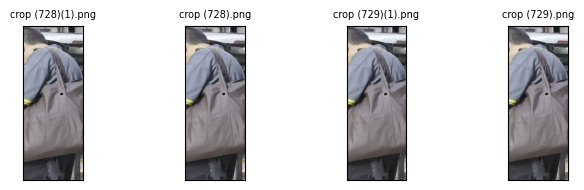

Set: 1


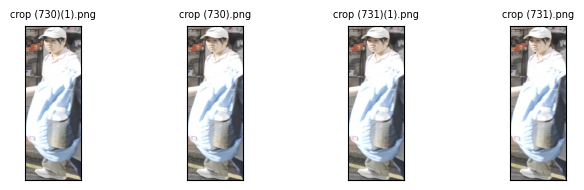

Set: 2


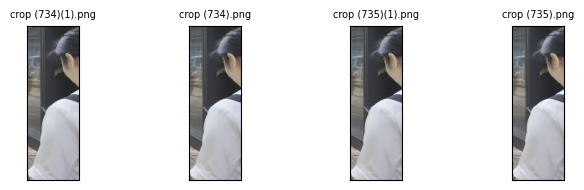

Set: 3


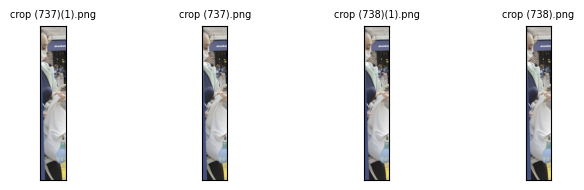

In [4]:
imagelab = Imagelab(data_path=str(data_path))

# Build issue types from config
issue_types = {issue: {} for issue in config['cleanvision']['issue_types']}

imagelab.find_issues(issue_types)
imagelab.report()

## Choice 2: imagededup

Goal: compare duplicate detection coverage and overlap on the same dataset.

Notes:
- imagededup supports multiple methods. We start with perceptual hashing (PHash) for a fair comparison
- compare counts and overlap, not just raw totals

In [5]:
from itertools import combinations
from pathlib import Path

try:
    from imagededup.methods import PHash
except ImportError:
    raise ImportError("imagededup not installed. Run: pip install imagededup")

# 1) Run imagededup with PHash
phasher = PHash()
encodings = phasher.encode_images(image_dir=str(data_path))
duplicates = phasher.find_duplicates(encoding_map=encodings, scores=True)

# Flatten imagededup duplicates into sets (names only)
imagededup_sets = []
seen = set()
for img, dup_list in duplicates.items():
    if not dup_list:
        continue
    group = sorted({Path(img).name, *[Path(d[0]).name for d in dup_list]})
    key = tuple(group)
    if key not in seen:
        imagededup_sets.append(group)
        seen.add(key)

# Get CleanVision duplicate groups (available after imagelab.find_issues)
if "imagelab" in globals():
    duplicate_sets = imagelab.info.get("exact_duplicates", {}).get("sets", [])
else:
    duplicate_sets = []

# Normalize CleanVision groups to names only
cleanvision_sets = []
for g in duplicate_sets or []:
    cleanvision_sets.append([Path(p).name for p in g])

# 2) Compare counts
cleanvision_count = len(cleanvision_sets) if cleanvision_sets else 0
imagededup_count = len(imagededup_sets)
print(f"CleanVision duplicate groups: {cleanvision_count}")
print(f"imagededup duplicate groups: {imagededup_count}")

# 3) Compare overlap between methods using pairwise duplicates
# Group-level comparisons are too strict because group boundaries differ.

def pairs_from_groups(groups):
    pair_set = set()
    for g in groups:
        for a, b in combinations(sorted(g), 2):
            pair_set.add((a, b))
    return pair_set

# CleanVision pairs
cleanvision_pairs = pairs_from_groups(cleanvision_sets or [])

# imagededup pairs
imagededup_pairs = set()
for img, dup_list in duplicates.items():
    for dup in dup_list:
        a, b = sorted([Path(img).name, Path(dup[0]).name])
        imagededup_pairs.add((a, b))

overlap_pairs = cleanvision_pairs & imagededup_pairs
only_cleanvision_pairs = cleanvision_pairs - imagededup_pairs
only_imagededup_pairs = imagededup_pairs - cleanvision_pairs

print(f"Pair overlap: {len(overlap_pairs)}")
print(f"Only CleanVision pairs: {len(only_cleanvision_pairs)}")
print(f"Only imagededup pairs: {len(only_imagededup_pairs)}")

# 4) Inspect a few mismatched pairs
print("Sample only imagededup pairs:", list(only_imagededup_pairs)[:5])
print("Sample only CleanVision pairs:", list(only_cleanvision_pairs)[:5])

2026-02-19 02:38:32,183: INFO Start: Calculating hashes...
100%|██████████| 1147/1147 [00:03<00:00, 287.53it/s]
2026-02-19 02:38:37,270: INFO End: Calculating hashes!
/Users/carlychinsekyi/miniconda3/envs/vision/lib/python3.13/site-packages/imagededup/methods/hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)
2026-02-19 02:38:37,271: INFO Start: Evaluating hamming distances for getting duplicates
2026-02-19 02:38:37,271: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 1147/1147 [00:03<00:00, 357.39it/s]
2026-02-19 02:38:41,505: INFO End: Retrieving duplicates using Cython Brute force algorithm
2026-02-19 02:38:41,505: INFO End: Evaluating hamming distances for getting duplicates


CleanVision duplicate groups: 133
imagededup duplicate groups: 135
Pair overlap: 163
Only CleanVision pairs: 0
Only imagededup pairs: 2
Sample only imagededup pairs: [('crop (374).png', 'crop (853).png'), ('crop (475).png', 'crop (937).png')]
Sample only CleanVision pairs: []


After manual inspection of imagededup-only pairs, the images are similar but not identical.

## Decision

Verdict: Choose imagededup (PHash)
- for scalability and faster duplicate mining on larger datasets.

Rationale:
- imagededup is optimized for duplicate discovery at scale
- CleanVision is better for comprehensive dataset auditing (blur, brightness, size, and duplicates).

In [6]:
from pathlib import Path

# Select method for downstream cleaning and evaluation
CHOSEN_METHOD = "imagededup"  # options: "imagededup" or "cleanvision"

if CHOSEN_METHOD == "imagededup":
    selected_groups = imagededup_sets
else:
    selected_groups = [[Path(p).name for p in g] for g in (duplicate_sets or [])]

print(f"Chosen method: {CHOSEN_METHOD}")
print(f"Duplicate groups for evaluation: {len(selected_groups)}")

Chosen method: imagededup
Duplicate groups for evaluation: 135


In [7]:
# Copy images to cleaned_raw, removing duplicates
# Strategy: Keep first image from each duplicate group, discard the rest

# Get all images first
all_images = set([f.name for f in data_path.glob('*.png')])
images_to_remove = set()

if selected_groups:
    print(f"Found {len(selected_groups)} duplicate groups using {CHOSEN_METHOD}")

    # Keep first image from each group, mark rest for removal
    for dup_group in selected_groups:
        if len(dup_group) > 1:
            for dup_name in dup_group[1:]:
                images_to_remove.add(Path(dup_name).name)

    print(f"Removing {len(images_to_remove)} duplicate images")
else:
    print("No duplicate groups found")

# Final set of images to keep
images_to_keep = all_images - images_to_remove

# Recreate cleaned_raw directory
cleaned_data_path = Path(f"../{config['paths']['cleaned_raw']}")
if cleaned_data_path.exists():
    shutil.rmtree(cleaned_data_path)
cleaned_data_path.mkdir(parents=True, exist_ok=True)

# Copy images
good_images = 0
for img in sorted(data_path.glob('*.png')):
    if img.name in images_to_keep:
        shutil.copy(img, cleaned_data_path / img.name)
        good_images += 1

print(f"\n{'='*50}")
print(f"Copied {good_images} images to cleaned_raw/")
print(f"Removed {len(images_to_remove)} duplicates")
print(f"{'='*50}")

Found 135 duplicate groups using imagededup
Removing 148 duplicate images

Copied 999 images to cleaned_raw/
Removed 148 duplicates


In [8]:
# Verify cleaned dataset
clean_image_count = len(list(cleaned_data_path.rglob('*.png')))
print(f"Total images in cleaned_raw: {clean_image_count}")

Total images in cleaned_raw: 999


## Check if Specific Image was Filtered

'crop (42).png' was FILTERED (failed quality checks)

Reason: Check issues in CleanVision report above


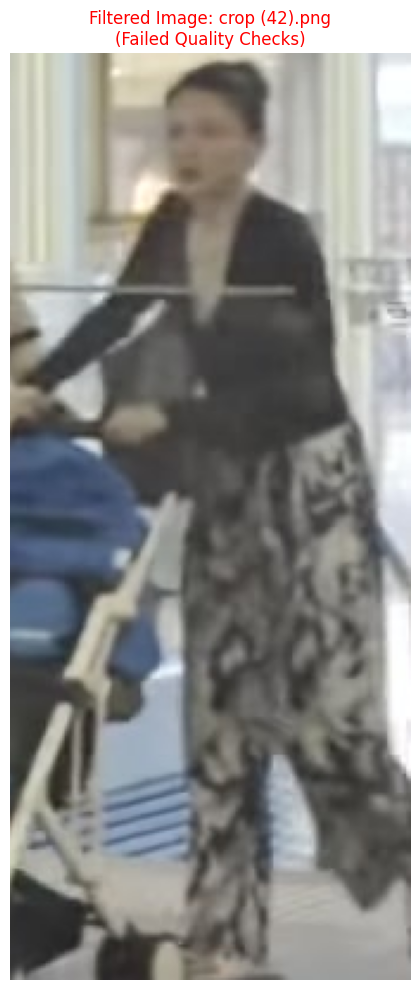

In [9]:
import cv2
import matplotlib.pyplot as plt

# Change this to check a different image
check_image_name = 'crop (42).png'

original_path = data_path / check_image_name
cleaned_path = cleaned_data_path / check_image_name

if cleaned_path.exists():
    print(f"✅ '{check_image_name}' was KEPT (passed quality checks)")
    print(f"Location: {cleaned_path}")
    
    # Display the image
    img = cv2.imread(str(cleaned_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 10))
    plt.imshow(img_rgb)
    plt.title(f"Kept Image: {check_image_name}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
elif original_path.exists():
    print(f"'{check_image_name}' was FILTERED (failed quality checks)")
    print(f"\nReason: Check issues in CleanVision report above")
    
    # Find issues for this image
    issues_df = imagelab.issues
    image_row = issues_df[issues_df.index == check_image_name]
    
    if not image_row.empty:
        print(f"\nDetected issues:")
        issue_cols = [col for col in issues_df.columns if col.startswith('is_')]
        for col in issue_cols:
            if image_row[col].values[0]:
                issue_name = col.replace('is_', '').replace('_issue', '')
                print(f"  - {issue_name}")
    
    # Display the filtered image
    img = cv2.imread(str(original_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 10))
    plt.imshow(img_rgb)
    plt.title(f"Filtered Image: {check_image_name}\n(Failed Quality Checks)", color='red')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
else:
    print(f"'{check_image_name}' not found in original dataset")
    print(f"Available images: {sorted([f.name for f in data_path.glob('*.png')])[:10]}...")
